# Self-Driving Car Engineer Nanodegree


## Project: Advanced Lane Finding
---
The goal of this project is to create a software pipeline to identify the lane boundaries in a video from a front-facing camera on a car. 

The steps of the project are the following:

1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
2. Apply a distortion correction to raw images.
3. Use color transforms, gradients, etc., to create a thresholded binary image.
4. Apply a perspective transform to rectify binary image ("birds-eye view").
5. Detect lane pixels and fit to find the lane boundary.
6. Determine the curvature of the lane and vehicle position with respect to center.
7. Warp the detected lane boundaries back onto the original image.
8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
 

### 1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images

The following code calculates the camera matrix and distortion coefficients using the images in the *"camera_cal"* folder. It was adopted from original Udacity [source](https://github.com/udacity/CarND-Camera-Calibration)

First we are using OpenCV library to extract object points `objpoints` and image points `imgpoints` needed for camera calibration.

Then, calibrate, calculate distortion coefficients. The camera calibration matrix and distortion coefficients are saved in file `dist_pickle.p`

In [1]:
import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
#%matplotlib qt
%matplotlib inline

# number of inside corners in x and y
nx = 9
ny = 6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Keep filenames of image with not found corners to test camera calibration 
test_fnames = []
                 
# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    # Read a file
    img = cv2.imread(fname)
    # Covert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # get filename
    filename = fname.split('\\')[-1]
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        write_name = 'camera_cal/'+'corners_'+filename
        cv2.imwrite(write_name, img)
        cv2.waitKey(500)
    else:
        test_fnames.append(fname)

#cv2.destroyAllWindows()

img = cv2.imread('camera_cal/calibration1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/dist_pickle.p", "wb" ) )

print('Number of images with detected corners =', len(imgpoints))
print('Number of images with not detected corners =', len(test_fnames))

Number of images with detected corners = 17
Number of images with not detected corners = 3


Visualization utilities

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

def plt_one(image, title = None, cmap=None):
    figure, ax = plt.subplots(figsize=(9, 6))
    ax.imshow(image, cmap=cmap)
    ax.set_title(title)
    plt.show()
    return figure
    
def plt_two(image_1, image_2, title_1 = None, title_2 = None, cmap=None):
    figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(image_1)
    ax1.set_title(title_1, fontsize=30)
    ax2.imshow(image_2, cmap=cmap)
    ax2.set_title(title_2, fontsize=30)
    plt.show()
    return figure

A chessboard image with detected corners

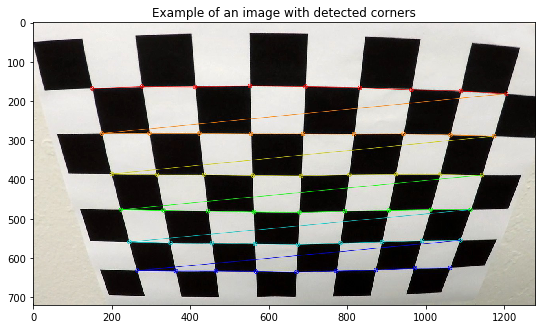

In [15]:
image = cv2.imread('camera_cal/corners_calibration2.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

figure = plt_one(image, "Example of an image with detected corners")
plt.close(figure)    # close the figure

In 3 images the corners could not be detected because the number of cross points is not corresponding to the defined values of nx = 9 and ny = 6. I will use those images to test undistortion. 

### 2. Apply a distortion correction to raw images

First test a chessboard image

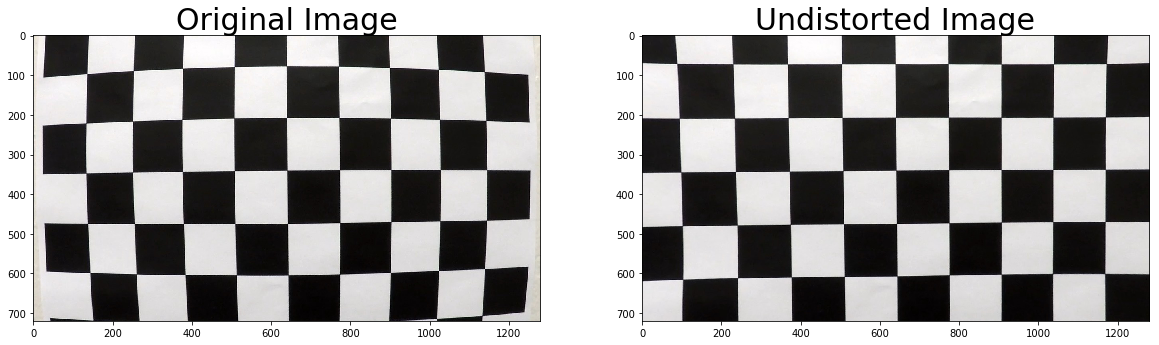

In [16]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def undistort(image, dist_pickle_fname):
    """
    The function reads in the saved camera matrix and distortion coefficients
    and undistort the input image
    Returns an undistorted image "undist"
    """    
    # Read in the saved camera matrix and distortion coefficients
    dist_pickle = pickle.load( open(dist_pickle_fname, "rb"))
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]        
    # Undistort using mtx and dist
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    return undist

# Test on chessboard image
image = cv2.imread(test_fnames[0])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
undist = undistort(image, "camera_cal/dist_pickle.p")

# Visualize undistortion
figure = plt_two(image, undist, 'Original Image', 'Undistorted Image')
figure.savefig('output_images/test_calibration.jpg')   # save the figure to file
plt.close(figure)    # close the figure

Now apply undistortion to raw images

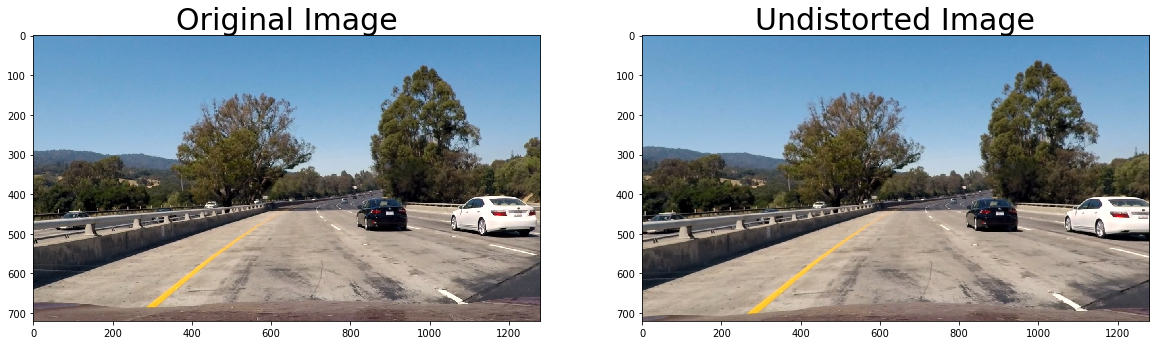

In [17]:
# Test on a raw test image
image = cv2.imread('test_images/test1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
undist = undistort(image, "camera_cal/dist_pickle.p")

# Visualize undistortion
figure = plt_two(image, undist, 'Original Image', 'Undistorted Image')
figure.savefig('output_images/test_undistortion.jpg')   # save the figure to file
plt.close(figure)    # close the figure

### 3. Use color transforms, gradients, etc., to create a thresholded binary image

It's not clear what exactly the best result should be - have to figure out later on

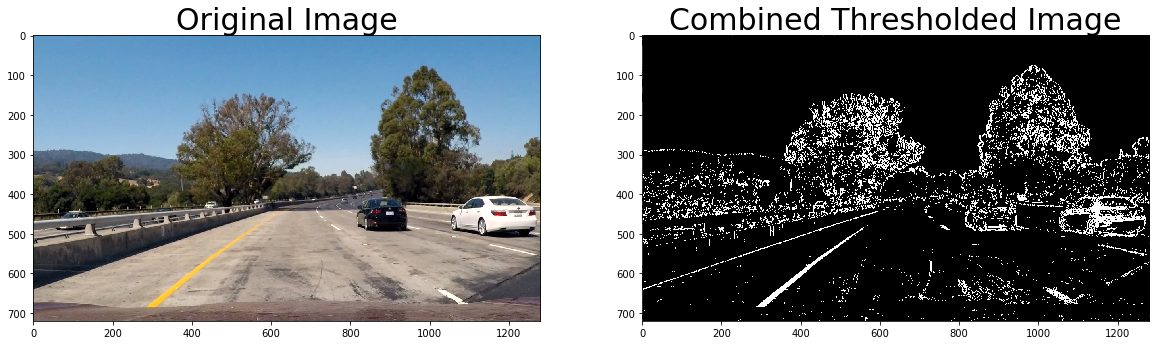

In [119]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)        
    if orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)   
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
    # is > thresh_min and < thresh_max
    # Apply threshold
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    grad_binary = np.copy(sxbinary) 
    # Apply threshold
    return grad_binary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    # 5) Create a binary mask where mag thresholds are met
    # Apply threshold
    sxbinary = np.zeros_like(gradmag)
    sxbinary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    mag_binary = np.copy(sxbinary)
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    # Apply threshold
    sxbinary = np.zeros_like(grad_dir)
    sxbinary[(grad_dir >= thresh[0]) & (grad_dir <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    dir_binary = np.copy(sxbinary)
    return dir_binary

def combined_binary(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel > s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    color_binary = np.uint8(color_binary)    
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary
    
# Read a test image
image = cv2.imread('test_images/test1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 100))
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100))
#dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0, np.pi/2))
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.9, 1.3))
comb_binary = combined_binary(image, s_thresh=(200, 255))


combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (comb_binary == 1)] = 1


# Visualize binary image
figure = plt_two(image, combined, 'Original Image', 'Combined Thresholded Image', cmap='gray')
figure.savefig('output_images/combined_treshold_binary.jpg')   # save the figure to file
plt.close(figure)    # close the figure

### 4. Apply a perspective transform to rectify binary image ("birds-eye view")

First draw lines lines on the test image to find corners for perspective transform. Use straight line to check if the output lines are drawing a rectangle. Draw lines on top of the lane lines.

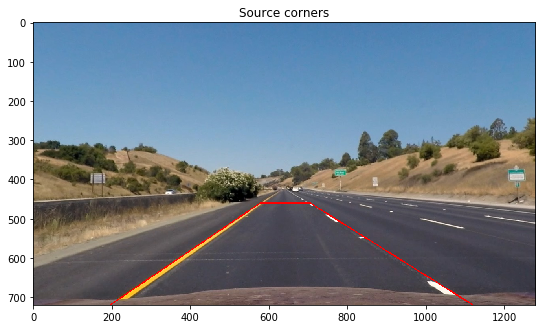

In [121]:
# Read a test image
image = cv2.imread('test_images/straight_lines1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Remove distortion
image = undistort(image, "camera_cal/dist_pickle.p")

def mark_lines(image, tl, tr, br, bl, col=[255,0,0], thick=1):
    # Draw lines on the image
    cv2.line(image, tl, tr, color=col, thickness=thick)
    cv2.line(image, tr, br, color=col, thickness=thick)
    cv2.line(image, br, bl, color=col, thickness=thick)
    cv2.line(image, bl, tl, color=col, thickness=thick)
    return image

# Define corner points
# top-left
tl_x = 578
tl_y = 460          

# top-right
tr_x = 705
tr_y = 460

# bottom-right
br_x = 1120
br_y = image.shape[0]

# bottom-left
bl_x = 195
bl_y = image.shape[0]  

# Draw lines on the image
image = mark_lines(image, (tl_x, tl_y), (tr_x, tr_y), (br_x, br_y), (bl_x, bl_y), thick=2)

# Visualize mark lines
figure = plt_one(image, "Source corners")
plt.close(figure)    # close the figure
figure.savefig('output_images/mark_straight_lines.jpg')   # save the figure to file
plt.close(figure)    # close the figure

The line are ok, now do the perspective transform. The sorce points are the end points of the drawn lines. The distanayion points are the outer corners of the image minus an offset of 100 pixels. The order of the corners will be: top-left->top-right->bottom-right->bottom-left. Use a technich described in [post](https://www.pyimagesearch.com/2014/08/25/4-point-opencv-getperspective-transform-example/) to define the destination corner points.

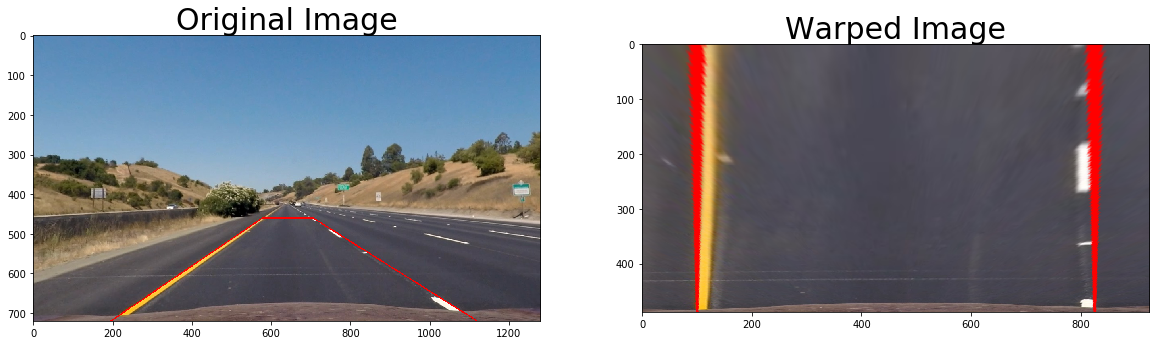

In [131]:

def warp_top_down(image, tl, tr, bl, br, offset=100):
    """
    Warps an image to a top-down view
    """
    # get source corners
    src = np.float32([tl,tr,br,bl])
    
    # Define distanation corner points are at the outer coners of the image
    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
 
    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-rightint()
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    
    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    tl = [offset, -offset]
    tr = [maxWidth-offset-1, -offset]
    br = [maxWidth-offset-1, maxHeight]
    bl = [offset, maxHeight]
    dst = np.float32([tl,tr,br,bl])
    
    # get the transform matrix M
    M = cv2.getPerspectiveTransform(src, dst)
    
    # wrap the image
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight), flags=cv2.INTER_LINEAR)
    return warped

# Read a test image
image = cv2.imread('test_images/straight_lines1.jpg')
#image = cv2.imread('test_images/test5.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Remove distortion
image = undistort(image, "camera_cal/dist_pickle.p")

# Define corner points
tl = [tl_x, tl_y]           # top-left
tr = [tr_x, tr_y]           # top-right
br = [br_x, br_y] # bottom-right
bl = [bl_x, bl_y]  # bottom-left

# Draw lines on the image
image = mark_lines(image, (tl_x, tl_y), (tr_x, tr_y), (br_x, br_y), (bl_x, bl_y), thick=2)

# Warp to top-down view
top_down = warp_top_down(image, tl, tr, bl, br, offset=100)

# Visualize perspective transform
figure = plt_two(image, top_down, 'Original Image', 'Warped Image')
figure.savefig('output_images/test_warped.jpg')   # save the figure to file
plt.close(figure)    # close the figure

By some reason the mark lines look different than in the examples but it is fine for now.

### 5. Detect lane pixels and fit to find the lane boundary

### 6. Determine the curvature of the lane and vehicle position with respect to center

### 7. Warp the detected lane boundaries back onto the original image

### 8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position


In [ ]:
def pipeline(image):
    
    # remove distortion
    undist = undistort_image(image, "camera_cal/dist_pickle.p")
    result = np.copy(undist)
    
    return result

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
import numpy as np
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    result = pipeline(image)
    #result = np.copy(image)
    
    return result    

In [ ]:
#if os.path.exists('test_videos_output/'):
#    pass
#else:
#    os.mkdir('test_videos_output/')

white_output = 'project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))